In [1]:
import yaml
import numpy as np
import time

In [2]:
#import scripts files
from scripts.vision import Vision
from scripts.global_nav import GlobalNav
from scripts.local_nav import LocalNav
from utils import utils

In [3]:
!pip install -r requirements.txt

In [4]:
# Load the configuration file
with open('config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Controller configuration
angle_tolerance = config['controller']['angle_tolerance'] #degrees
distance_tolerance = config['controller']['distance_tolerance'] #mm
scale_rotation_speed = config['controller']['scale_rotation_speed'] 
max_rotation_speed = config['controller']['max_rotation_speed'] 
scale_translation_speed = config['controller']['scale_translation_speed'] 
min_translation_speed = config['controller']['min_translation_speed'] 
max_translation_speed = config['controller']['max_translation_speed'] 

# World configuration
world_width = config['world']['width'] #mm
world_height = config['world']['height'] #mm
obstacle_min_area = config['world']['obstacle_min_area'] #mm²

# Thymio configuration
thymio_size = config['thymio']['size'] #mm

# Webcam configuration
webcam_device_id = config['webcam']['device_id']
webcam_matrix = np.array(config['webcam']['matrix'])
webcam_distortion = np.array(config['webcam']['distortion'])
webcam_resolution = config['webcam']['resolution']
webcam_padding = config['webcam']['padding']
scale_factor = webcam_resolution[1] / world_width


In [5]:
vision = Vision(
    device_id=webcam_device_id,
    camera_matrix=webcam_matrix,
    dist_coeffs=webcam_distortion,
    resolution=webcam_resolution,
    padding=webcam_padding,
    scale_factor=scale_factor,
    world_width=world_width,
    world_height=world_height
    
)
global_nav = GlobalNav(
    world_width=world_width,
    world_height=world_height,
    obstacle_min_area=obstacle_min_area,
    thymio_size=thymio_size,
    scale_factor=scale_factor
)

local_nav = LocalNav(
    angle_threshold=angle_tolerance,
    distance_threshold=distance_tolerance,
    scale_rotation_speed=scale_rotation_speed,
    max_rotation_speed=max_rotation_speed,
    scale_translation_speed=scale_translation_speed,
    min_translation_speed=min_translation_speed,
    max_translation_speed=max_translation_speed
)

Vision Initialized
GlobalNav Initialized
LocalNav Initialized


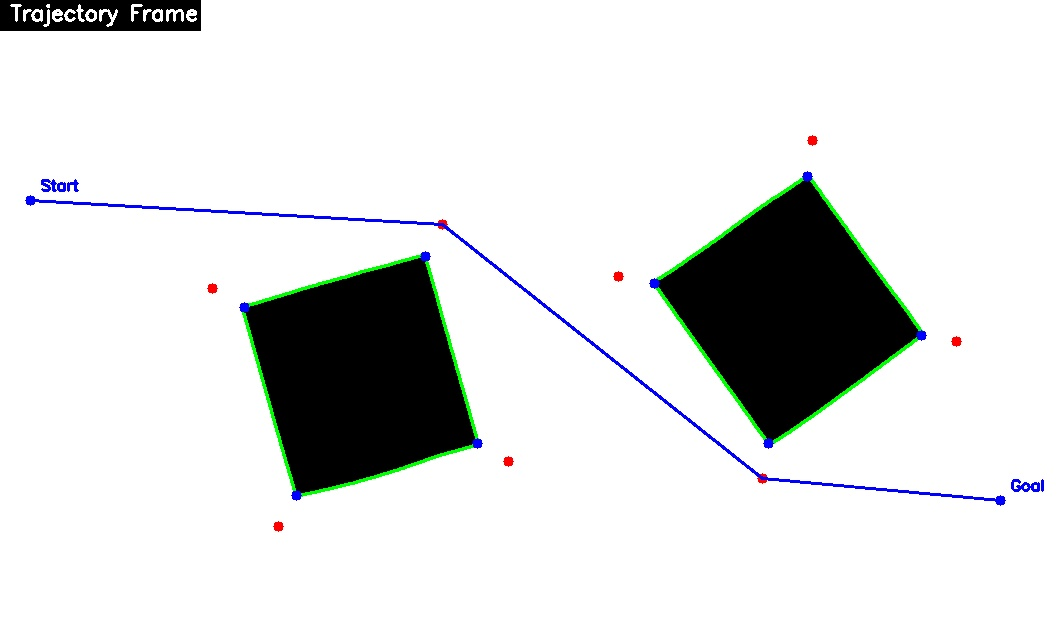

In [6]:
got_trajectory = False
trajectory_frame = None
trajectory_pos_mm = None
obstacles_pos_mm = None
current_thymio_pos_mm = None
current_thymio_orientation_rad = None

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
        
    while not got_trajectory:
        frame, process_frame, thymio_pos_pixels, goal_pos_pixels= vision.get_frame()
        thymio_pos_pixels = {"thymio": np.array([30, 200])}
        goal_pos_pixels = {"goal": np.array([1000, 500])}
        
        if thymio_pos_pixels["thymio"] is not None:
            current_thymio_pos_mm = np.array([utils.pixels_to_mm(thymio_pos_pixels["thymio"][0], scale_factor), utils.pixels_to_mm(thymio_pos_pixels["thymio"][1], scale_factor)])
            
        current_thymio_orientation_rad = 0
        trajectory_frame, trajectory_pos_pixels, obstacles_pos_pixels, got_trajectory = global_nav.get_trajectory(process_frame, thymio_pos_pixels, goal_pos_pixels)
        
        # Convert obstacles points to mm
        if obstacles_pos_pixels is not None:
            obstacles_pos_mm = {
                key: np.array([[utils.pixels_to_mm(point[0], scale_factor), utils.pixels_to_mm(point[1], scale_factor)] for point in points]) for key, points in obstacles_pos_pixels.items()
            }
            
        # Convert trajectory points to mm
        if trajectory_pos_pixels is not None:
            trajectory_pos_mm = np.array([[utils.pixels_to_mm(point[0], scale_factor), utils.pixels_to_mm(point[1], scale_factor)] for point in trajectory_pos_pixels])
        
        utils.display_frames(frame, process_frame, None) 
        time.sleep(0.1)
        
except KeyboardInterrupt:
    display("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.cleanup_webcam()
    time.sleep(2)
    utils.display_frames(None, None, trajectory_frame)

In [7]:
print(f"Obstacles [mm]: \n {obstacles_pos_mm}")
print(f"Trajectory points [mm]:\n {trajectory_pos_mm}")
print(f"Thymio position [mm]:\n {current_thymio_pos_mm}")
print(f"Thymio orientation [mm]:\n {current_thymio_orientation_rad}")
print(f"Goal position [mm]:\n {trajectory_pos_mm[-1]}")

Obstacles [mm]: 
 {'obstacle1': array([[122.81305,  62.3153 ],
       [ 59.14941,  80.22296],
       [ 77.48013, 146.30412],
       [141.14452, 128.08273]], dtype=float32), 'obstacle2': array([[225.61467 ,  38.994278],
       [171.85455 ,  76.68176 ],
       [211.89066 , 132.95094 ],
       [265.65234 ,  94.949486]], dtype=float32)}
Trajectory points [mm]:
 [[  8.33333333  55.55555556]
 [122.81304253  62.3152966 ]
 [211.89064874 132.9509396 ]
 [277.77777778 138.88888889]]
Thymio position [mm]:
 [ 8.33333333 55.55555556]
Thymio orientation [mm]:
 0
Goal position [mm]:
 [277.77777778 138.88888889]



Trajectory completed!


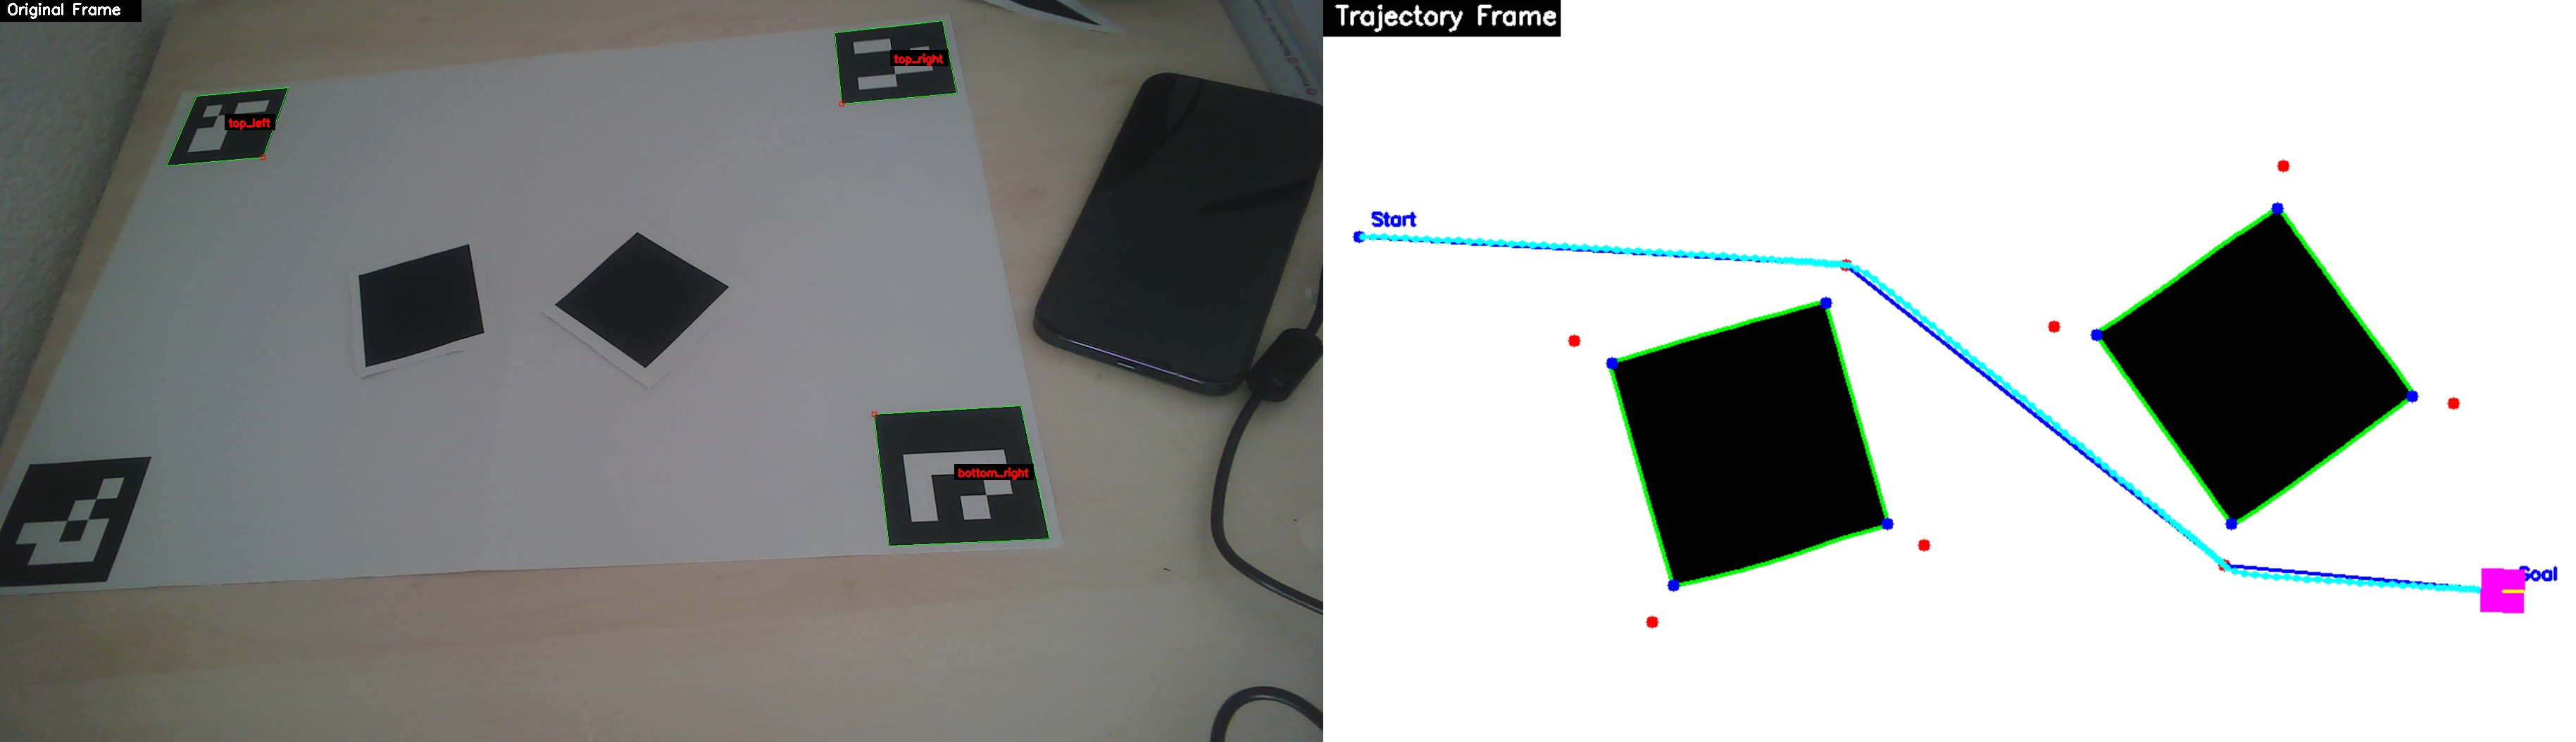

In [8]:
goal_reached = False
background_frame = None
position_history = []  # List to store previous positions

try:
    # Try connecting to the webcam
    display(f"Trying to connect to device {webcam_device_id}...")
    if not vision.connect_webcam():
        display("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        display(f"Successfully connected to device {webcam_device_id}")
    
    # If this is the first frame, create a copy of trajectory_frame as background
    if trajectory_frame is not None:
        background_frame = trajectory_frame.copy()
        
    while not goal_reached:
        original_frame, process_frame, _, _ = vision.get_frame() # get thymio position and goal position if not simulation
      
        # Get next command using updated position and orientation
        command, goal_reached = local_nav.navigate(trajectory_pos_mm, current_thymio_pos_mm, current_thymio_orientation_rad)
        
        # Simulate movement
        new_position, new_orientation = utils.simulate_robot_movement(
            current_thymio_pos_mm, current_thymio_orientation_rad, command
        )
        
        # Update current position and orientation
        current_thymio_pos_mm = new_position
        current_thymio_orientation_rad = new_orientation

        # Convert new_position from mm to pixels for drawing and store it
        new_position_pixels = np.array([utils.mm_to_pixels(new_position[0], scale_factor), utils.mm_to_pixels(new_position[1], scale_factor)])
        position_history.append(new_position_pixels)

        # Update trajectory frame with robot
        if background_frame is not None:
            current_frame = background_frame.copy()
            
            # Draw trajectory
            trajectory_frame = utils.draw_trajectory(current_frame, position_history)
            
            # Draw the current robot position
            thymio_size_pixels = np.array([
                utils.mm_to_pixels(thymio_size['width'], scale_factor), 
                utils.mm_to_pixels(thymio_size['length'], scale_factor)
            ])
            trajectory_frame = utils.draw_robot(current_frame, new_position_pixels, new_orientation, thymio_size_pixels)

        utils.display_frames(original_frame, process_frame, trajectory_frame) 
        time.sleep(0.01)
        
except KeyboardInterrupt:
   display("User interrupted the kernel. Closing the webcam...")
finally:
    # Release resources
    vision.cleanup_webcam()